In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
eps = 1e-10

In [5]:
def generator(noise_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(noise_in, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, these_vars

In [6]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [7]:
def EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, tf.reduce_mean(T_P, axis = 0)

In [28]:
targetdist = ds.Normal(loc = 1.0, scale = 0.1)

In [9]:
noise_in = tf.placeholder(tf.float32, [None, 2], name = 'noise_in')
target_in = tf.placeholder(tf.float32, [None, 1], name = 'target_in')

In [10]:
gen_out, gen_vars = generator(noise_in, "gen")

In [11]:
EM_loss, EM_vars, gen_loss = EM_loss(gen_out, target_in, "EM_loss")

In [91]:
train_EM = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.5, beta2 = 0.9).minimize(EM_loss, var_list = EM_vars)

In [103]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.5, beta2 = 0.9).minimize(-gen_loss, var_list = gen_vars)

In [104]:
sess.run(tf.global_variables_initializer())

In [105]:
# prepare noise
for i in range(20):
    target = sess.run(targetdist.sample(100, 1))
    target = np.expand_dims(target, axis = 1)
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (100, 2))
    sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})

    cur_gen_loss = sess.run(gen_loss, feed_dict = {noise_in: noise, target_in: target})
    print("loss = {}".format(cur_gen_loss))

loss = [-0.00115647]
loss = [-0.00228199]
loss = [-0.00359826]
loss = [-0.00412537]
loss = [-0.00475239]
loss = [-0.00629719]
loss = [-0.00681953]
loss = [-0.00727325]
loss = [-0.00867371]
loss = [-0.01009786]
loss = [-0.01074145]
loss = [-0.01015411]
loss = [-0.01061453]
loss = [-0.01143744]
loss = [-0.014134]
loss = [-0.01330374]
loss = [-0.0156208]
loss = [-0.0153648]
loss = [-0.01542136]
loss = [-0.01776487]


In [106]:
# compare initial distributions
target_test = sess.run(targetdist.sample(10000, 1))
noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (10000, 2))
gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})

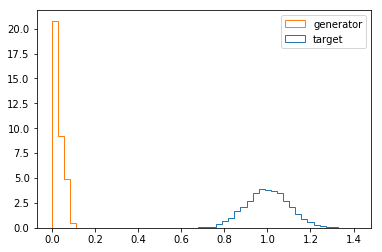

In [107]:
plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    # prepare noise
    for i in range(5):
        target = sess.run(targetdist.sample(1000, 1))
        target = np.expand_dims(target, axis = 1)
        noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 2))
        sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})
    
    target = sess.run(targetdist.sample(1000, 1))
    target = np.expand_dims(target, axis = 1)
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 2))
    sess.run(train_gen, feed_dict = {noise_in: noise, target_in: target})
    cur_gen_loss = sess.run(gen_loss, feed_dict = {noise_in: noise, target_in: target})
    critic_loss = sess.run(EM_loss, feed_dict = {noise_in: noise, target_in: target})
    
    print("W = {}".format(cur_gen_loss))
    print("critic loss = {}".format(critic_loss))

W = [-1.1816311]
critic loss = 0.07065153867006302
W = [-1.2396996]
critic loss = 0.05136694759130478
W = [-1.2097734]
critic loss = 0.05512624979019165
W = [-1.15969]
critic loss = 0.06745888292789459
W = [-1.1838908]
critic loss = 0.06474697589874268


In [145]:
# compare initial distributions
target_test = sess.run(targetdist.sample(10000, 1))
noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (10000, 2))
gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})

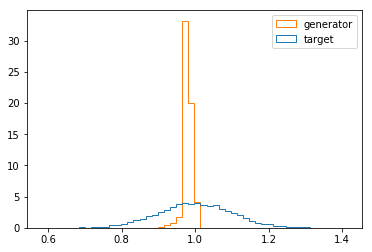

In [146]:
plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
plt.legend()
plt.show()